In [1]:
import re
import pickle
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

from utils import camelcase_to_underscore


sns.set(style="white", palette="muted", color_codes=True)

### Read Data (SMALL SAMPLE)
Все рассчеты произведены на маленьком сэмпле данных!

In [2]:
# Full
# df = pd.read_csv('input/train_V2.csv')
# Sample
df = pd.read_csv('input/train_V2.csv', nrows=10000)
df.columns = [camelcase_to_underscore(col) for col in df.columns]
display(df.head(), df.shape, list(df.columns))

,id,group_id,match_id,assists,boosts,damage_dealt,dbn_os,headshot_kills,heals,kill_place,...,revives,ride_distance,road_kills,swim_distance,team_kills,vehicle_destroys,walk_distance,weapons_acquired,win_points,win_place_perc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


(10000, 29)

['id',
 'group_id',
 'match_id',
 'assists',
 'boosts',
 'damage_dealt',
 'dbn_os',
 'headshot_kills',
 'heals',
 'kill_place',
 'kill_points',
 'kills',
 'kill_streaks',
 'longest_kill',
 'match_duration',
 'match_type',
 'max_place',
 'num_groups',
 'rank_points',
 'revives',
 'ride_distance',
 'road_kills',
 'swim_distance',
 'team_kills',
 'vehicle_destroys',
 'walk_distance',
 'weapons_acquired',
 'win_points',
 'win_place_perc']

### Drop NaN Target observations

In [3]:
df.drop(df[df['win_place_perc'].isnull()].index, inplace=True)

### Select Numerical Features

In [4]:
id_features = ['id', 'group_id', 'match_id']
categorical_features = ['match_type', ]
target_feature = 'win_place_perc'
base_features = [col for col in df.columns if col not in id_features + categorical_features + [target_feature]] 

### Count Unique Values

In [5]:
df['group_id'].nunique(), df['match_id'].nunique(), df['match_type'].nunique()

(9971, 9059, 15)

### Explore Target

count    10000.000000
mean         0.472508
std          0.307031
min          0.000000
25%          0.200000
50%          0.458300
75%          0.740700
max          1.000000
Name: win_place_perc, dtype: float64

/Users/dmitrymikhailovich_/cnt/pubg-kaggle/.direnv/python-3.6.3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


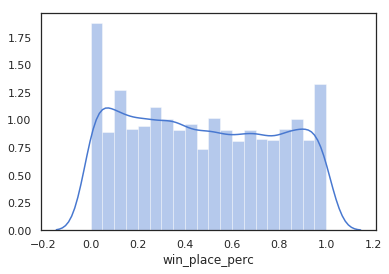

In [6]:
display(df[target_feature].describe())
sns.distplot(df[target_feature])
plt.show()

### Training

In [8]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from pipelines import Pipeline
from utils import save_model

kfold = KFold(n_splits = 2)
kfold.get_n_splits(df)
log = []
for train_index, valid_index in kfold.split(df):
    pipeline = Pipeline(
        id_columns=id_features, 
        numerical_columns=base_features,
        categorical_columns=categorical_features,
        target_column=target_feature,
    )
    x_train = pipeline.fit_transform(df.loc[train_index, :])
    y_train = df.loc[train_index, target_feature]
    x_valid = pipeline.transform(df.loc[valid_index, :])
    y_valid = df.loc[valid_index, target_feature]
    
#     model = Ridge(alpha=1)
    model = RandomForestRegressor(
        n_jobs=-1, 
        n_estimators=100, 
        criterion='mae', 
#         max_depth=5,
    )
    model.fit(x_train, y_train)
    step = dict()
    step['train_score'] = mean_absolute_error(y_train, model.predict(x_train))
    step['valid_score'] = mean_absolute_error(y_valid, model.predict(x_valid))
    step['model'] = model
    step['pipeline'] = pipeline
    step['train_index'] = train_index
    step['valid_index'] = valid_index
    try:
        save_model(step)
    except Exception:
        print("Warning: Couldn't save the model")
    print(step['train_score'], ['valid_score'])
    log.append(step)

{'train_score': 0.027029561599999995, 'valid_score': 0.0851845738}
{'train_score': 0.0269319453, 'valid_score': 0.0776228844}


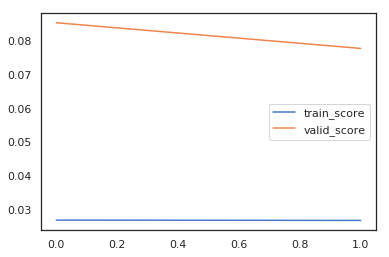

In [9]:
# df_scores = pd.DataFrame(log)
# df_scores.plot()
# plt.show()

### Feature Importance

https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance

In [51]:
import eli5
from eli5.sklearn import PermutationImportance

# Fitting
perm = PermutationImportance(model, random_state=42).fit(x_valid, y_valid)
eli5.show_weights(perm, feature_names=list(x_valid.columns), top=None)

Weight,Feature
0.0314 ± 0.0029,min_group_walk_distance
0.0277 ± 0.0020,max_group_kill_place
0.0137 ± 0.0013,mean_group_walk_distance
0.0137 ± 0.0011,min_group_kill_place
0.0123 ± 0.0026,mean_group_kill_place
0.0119 ± 0.0033,kill_place
0.0088 ± 0.0007,min_group_kills_per_walk_distance
0.0074 ± 0.0015,max_group_walk_distance
0.0055 ± 0.0004,max_group_kills_per_walk_distance
0.0053 ± 0.0006,kills_per_walk_distance


### Explore predictinos
of model, not perm

https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#explaining-weights

In [53]:
for i in (4242, 0, 100, 1200, 3096):
    display(eli5.show_prediction(
        model, 
        doc=x_valid.iloc[i], 
        feature_names=list(x_valid.columns), 
        show_feature_values=True, 
        top=10,
    ))

### Feature Selection

https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html#eli5-permutation-importance

In [65]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(perm, threshold=0.0001, prefit=True)
x_trans = sel.transform(x_train)

In [171]:
print(x_trans.shape)
important_features = [col for col in x_train.loc[:, sel.get_support()].columns]
important_features

(5000, 50)


['damage_dealt',
 'dbn_os',
 'kill_place',
 'kills',
 'longest_kill',
 'match_duration',
 'max_place',
 'num_groups',
 'walk_distance',
 'kills_norm',
 'damage_dealt_norm',
 'kills_per_walk_distance',
 'mean_group_boosts',
 'mean_group_damage_dealt',
 'mean_group_dbn_os',
 'mean_group_kill_place',
 'mean_group_kills',
 'mean_group_kill_streaks',
 'mean_group_longest_kill',
 'mean_group_match_duration',
 'mean_group_max_place',
 'mean_group_num_groups',
 'mean_group_walk_distance',
 'mean_group_total_distance',
 'mean_group_kills_norm',
 'mean_group_kills_per_walk_distance',
 'max_group_damage_dealt',
 'max_group_dbn_os',
 'max_group_kill_place',
 'max_group_kill_streaks',
 'max_group_longest_kill',
 'max_group_match_duration',
 'max_group_max_place',
 'max_group_num_groups',
 'max_group_walk_distance',
 'max_group_kills_norm',
 'max_group_damage_dealt_norm',
 'max_group_kills_per_walk_distance',
 'min_group_dbn_os',
 'min_group_kill_place',
 'min_group_kills',
 'min_group_kill_streaks'

In [69]:
x_train.loc[:, sel.get_support()].head()

,damage_dealt,dbn_os,kill_place,kills,longest_kill,match_duration,max_place,num_groups,walk_distance,kills_norm,...,min_group_kills,min_group_kill_streaks,min_group_longest_kill,min_group_match_duration,min_group_max_place,min_group_num_groups,min_group_walk_distance,min_group_kills_norm,min_group_damage_dealt_norm,min_group_kills_per_walk_distance
0,0.000000,0.0,0.595960,0.000000,0.000000,0.508820,0.225806,0.252525,0.026252,0.000000,...,0.000000,0.00,0.000000,0.508820,0.225806,0.252525,0.026252,0.000000,0.000000,0.000000
1,0.039342,0.0,0.565657,0.000000,0.000000,0.768467,0.204301,0.242424,0.153780,0.000000,...,0.000000,0.00,0.000000,0.768467,0.204301,0.242424,0.153780,0.000000,0.039144,0.000000
2,0.029247,0.0,0.464646,0.000000,0.000000,0.515436,0.462366,0.464646,0.017351,0.000000,...,0.000000,0.00,0.000000,0.515436,0.462366,0.464646,0.017351,0.000000,0.029247,0.000000
3,0.014151,0.0,0.747475,0.000000,0.000000,0.580485,0.258065,0.292929,0.021737,0.000000,...,0.000000,0.00,0.000000,0.580485,0.258065,0.292929,0.021737,0.000000,0.014008,0.000000
4,0.043011,0.0,0.444444,0.047619,0.093768,0.573870,0.967742,0.949495,0.005335,0.047619,...,0.047619,0.25,0.093768,0.573870,0.967742,0.949495,0.005335,0.047619,0.043011,0.003284


### Training

In [169]:
sel = SelectFromModel(perm, threshold=0.0001, prefit=True)
x_train_sel = sel.transform(x_train)
x_valid_sel = sel.transform(x_valid)
x_train_sel.shape

(5000, 50)

In [187]:
%%time
from sklearn.model_selection import cross_validate

model_sel = RandomForestRegressor(
    n_jobs=-1, 
    n_estimators=20, 
    criterion='mae', 
    max_depth=10,
    verbose=1
)
x = sel.transform(pipeline.transform(df))
scores = cross_validate(model_sel, x, df[target_feature], cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 575 ms, sys: 194 ms, total: 769 ms
Wall time: 1min 40s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


In [190]:
print(scores['test_score'], np.mean(scores['test_score']))

[-0.07263525 -0.06887668 -0.07155848] -0.07102346632211211
